# Synthetic Discussions analysis

## Preprocessing

In [34]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import re
import shutil

import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

from tasks.graphs import save_plot
from tasks.stats import ndfu
import tasks.stats


def get_annotations(annot_str: str) -> dict:
    """Extracts all key-value pairs from the annotation string into a dictionary."""
    try:
        annot_str = str(annot_str).lower()
        # Regex to match key-value pairs of the form type=value
        pattern = r"(\w+)=([-\d\.]+)"
        matches = re.findall(pattern, annot_str)
        return {
            key: float(value) if "." in value else int(value) for key, value in matches
        }
    except Exception as e:
        return {}


def get_user_intent(prompt: str) -> str:
    prompt = prompt.lower()

    if "community" in prompt:
        return "Community-oriented"
    elif "troll" in prompt:
        return "Troll"
    elif "special_instructions: ," in prompt:
        return "Neutral"
    else:
        return "Unknown"


def format_dataset(df: pd.DataFrame, min_message_len: int) -> pd.DataFrame:
    df = df.astype(str)

    # Extract all annotations from the 'annotation' column
    annotations = df["annotation"].apply(get_annotations)

    # Convert each annotation dictionary into separate columns
    annotations_df = pd.json_normalize(annotations)

    # Concatenate the new columns with the original dataframe
    df = pd.concat([df, annotations_df], axis=1)
    df = df[(df.toxicity != -1) | (df.argumentquality != -1)]

    df.message_order = df.message_order.astype(int)

    # Process other columns as needed
    df.is_moderator = (df.is_moderator == "True").astype(bool)
    df["intent"] = df.user_prompt.apply(get_user_intent).astype(str)
    df.intent = np.where(df.is_moderator, "Moderator", df.intent).astype(str)

    df["polarization"] = (
        df.groupby(["conv_id", "message"])["toxicity"]
        .transform(lambda x: ndfu(x, histogram_input=False))
        .astype(float)
    )

    df["not_intervened"] = (
        df.is_moderator & df.message.apply(lambda x: len(x.strip()) < min_message_len)
    ).astype(bool)

    df = df.loc[
        :,
        [
            "conv_id",
            "message_id",
            "message_order",
            "conv_variant",
            "model",
            "user",
            "user_prompt",
            "is_moderator",
            "intent",
            "message",
        ]
        + list(annotations_df.columns)
        + ["polarization", "not_intervened"],
    ]
    return df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
MODERATION_STRATEGY_MAP = {
    "vanilla": "No Instructions",
    "moderation_game": "Moderation Game",
    "no_moderator": "No Moderator",
    "erulemaking": "Human Mod. Guidelines",
    "constructive_communications": "Human Fac. Guidelines",
    "collective_constitution": "Rules Only"
}

In [36]:
nltk.download('punkt_tab')
tqdm.tqdm.pandas()

[nltk_data] Downloading package punkt_tab to /home/dimits/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [37]:
shutil.unpack_archive("../data/dataset.zip", "../data")
full_df = pd.read_csv("../data/dataset.csv", encoding="utf8")
full_df.conv_variant = full_df.conv_variant.map(MODERATION_STRATEGY_MAP)
full_df = format_dataset(full_df, min_message_len=3)
full_df = full_df.rename({"argumentquality": "Argument Quality"}, axis=1)
full_df

,conv_id,message_id,message_order,conv_variant,model,user,user_prompt,is_moderator,intent,message,toxicity,Argument Quality,polarization,not_intervened
0,b7674ce3-6caf-443a-b076-b6ae35f421a2,741081141450932242,1,No Instructions,hardcoded,RebelCoder07,You are a human participating in an online cha...,False,Neutral,"In other words, he’s not brown enough for ya t...",2,3,0.833333,False
1,b7674ce3-6caf-443a-b076-b6ae35f421a2,741081141450932242,1,No Instructions,hardcoded,RebelCoder07,You are a human participating in an online cha...,False,Neutral,"In other words, he’s not brown enough for ya t...",2,3,0.833333,False
2,b7674ce3-6caf-443a-b076-b6ae35f421a2,741081141450932242,1,No Instructions,hardcoded,RebelCoder07,You are a human participating in an online cha...,False,Neutral,"In other words, he’s not brown enough for ya t...",3,2,0.833333,False
3,b7674ce3-6caf-443a-b076-b6ae35f421a2,741081141450932242,1,No Instructions,hardcoded,RebelCoder07,You are a human participating in an online cha...,False,Neutral,"In other words, he’s not brown enough for ya t...",3,2,0.833333,False
4,b7674ce3-6caf-443a-b076-b6ae35f421a2,741081141450932242,1,No Instructions,hardcoded,RebelCoder07,You are a human participating in an online cha...,False,Neutral,"In other words, he’s not brown enough for ya t...",2,3,0.833333,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61142,c8c3eda7-92ec-4880-a6cf-4b26bb1f3815,1928277485472945723,29,Human Fac. Guidelines,mistral-nemo-abliterated,moderator,You are a human participating in an online cha...,True,Moderator,"@AdventureSeeker34, thank you for clarifying y...",1,3,0.000000,False
61143,c8c3eda7-92ec-4880-a6cf-4b26bb1f3815,1928277485472945723,29,Human Fac. Guidelines,mistral-nemo-abliterated,moderator,You are a human participating in an online cha...,True,Moderator,"@AdventureSeeker34, thank you for clarifying y...",1,3,0.000000,False
61144,c8c3eda7-92ec-4880-a6cf-4b26bb1f3815,1928277485472945723,29,Human Fac. Guidelines,mistral-nemo-abliterated,moderator,You are a human participating in an online cha...,True,Moderator,"@AdventureSeeker34, thank you for clarifying y...",1,3,0.000000,False
61145,c8c3eda7-92ec-4880-a6cf-4b26bb1f3815,1928277485472945723,29,Human Fac. Guidelines,mistral-nemo-abliterated,moderator,You are a human participating in an online cha...,True,Moderator,"@AdventureSeeker34, thank you for clarifying y...",1,3,0.000000,False


In [38]:
df = full_df[~full_df.not_intervened]
df

,conv_id,message_id,message_order,conv_variant,model,user,user_prompt,is_moderator,intent,message,toxicity,Argument Quality,polarization,not_intervened
0,b7674ce3-6caf-443a-b076-b6ae35f421a2,741081141450932242,1,No Instructions,hardcoded,RebelCoder07,You are a human participating in an online cha...,False,Neutral,"In other words, he’s not brown enough for ya t...",2,3,0.833333,False
1,b7674ce3-6caf-443a-b076-b6ae35f421a2,741081141450932242,1,No Instructions,hardcoded,RebelCoder07,You are a human participating in an online cha...,False,Neutral,"In other words, he’s not brown enough for ya t...",2,3,0.833333,False
2,b7674ce3-6caf-443a-b076-b6ae35f421a2,741081141450932242,1,No Instructions,hardcoded,RebelCoder07,You are a human participating in an online cha...,False,Neutral,"In other words, he’s not brown enough for ya t...",3,2,0.833333,False
3,b7674ce3-6caf-443a-b076-b6ae35f421a2,741081141450932242,1,No Instructions,hardcoded,RebelCoder07,You are a human participating in an online cha...,False,Neutral,"In other words, he’s not brown enough for ya t...",3,2,0.833333,False
4,b7674ce3-6caf-443a-b076-b6ae35f421a2,741081141450932242,1,No Instructions,hardcoded,RebelCoder07,You are a human participating in an online cha...,False,Neutral,"In other words, he’s not brown enough for ya t...",2,3,0.833333,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61142,c8c3eda7-92ec-4880-a6cf-4b26bb1f3815,1928277485472945723,29,Human Fac. Guidelines,mistral-nemo-abliterated,moderator,You are a human participating in an online cha...,True,Moderator,"@AdventureSeeker34, thank you for clarifying y...",1,3,0.000000,False
61143,c8c3eda7-92ec-4880-a6cf-4b26bb1f3815,1928277485472945723,29,Human Fac. Guidelines,mistral-nemo-abliterated,moderator,You are a human participating in an online cha...,True,Moderator,"@AdventureSeeker34, thank you for clarifying y...",1,3,0.000000,False
61144,c8c3eda7-92ec-4880-a6cf-4b26bb1f3815,1928277485472945723,29,Human Fac. Guidelines,mistral-nemo-abliterated,moderator,You are a human participating in an online cha...,True,Moderator,"@AdventureSeeker34, thank you for clarifying y...",1,3,0.000000,False
61145,c8c3eda7-92ec-4880-a6cf-4b26bb1f3815,1928277485472945723,29,Human Fac. Guidelines,mistral-nemo-abliterated,moderator,You are a human participating in an online cha...,True,Moderator,"@AdventureSeeker34, thank you for clarifying y...",1,3,0.000000,False


## Analysis

### User intent impact on toxicity

In [39]:
METRICS = ["toxicity", "Argument Quality", "polarization"]
GRAPH_OUTPUT_DIR = Path("../graphs")
TOXICITY_TICKS = np.arange(1, 6, 1)
POLARIZATION_TICKS = np.arange(0, 1.2, 0.2)

sns.set(style="whitegrid")


def plot_metrics_barplots(group_by_col: str, group_by_col_label: str) -> None:
    fig, axes = plt.subplots(1, len(METRICS))
    fig.set_size_inches(12, 6)

    for ax, metric in zip(axes, METRICS):

        sns.barplot(
            data=df,
            x=group_by_col,
            hue=group_by_col,
            y=metric,
            errorbar="sd",
            legend=False,
            ax=ax,
        )
        ax.tick_params(axis="x", labelrotation=90, labelsize=8)
        ax.set_xlabel("")
        ax.set_ylabel(metric.capitalize())
        if metric == "toxicity" or metric == "Argument Quality":
            ax.set_yticks(TOXICITY_TICKS)
        else:
            ax.set_yticks(POLARIZATION_TICKS)

    fig.suptitle(f"Impact of {group_by_col_label} on Discussions")
    fig.supxlabel(group_by_col_label)
    fig.supylabel("Annotation Scores")
    fig.tight_layout()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/intent_barplot.png


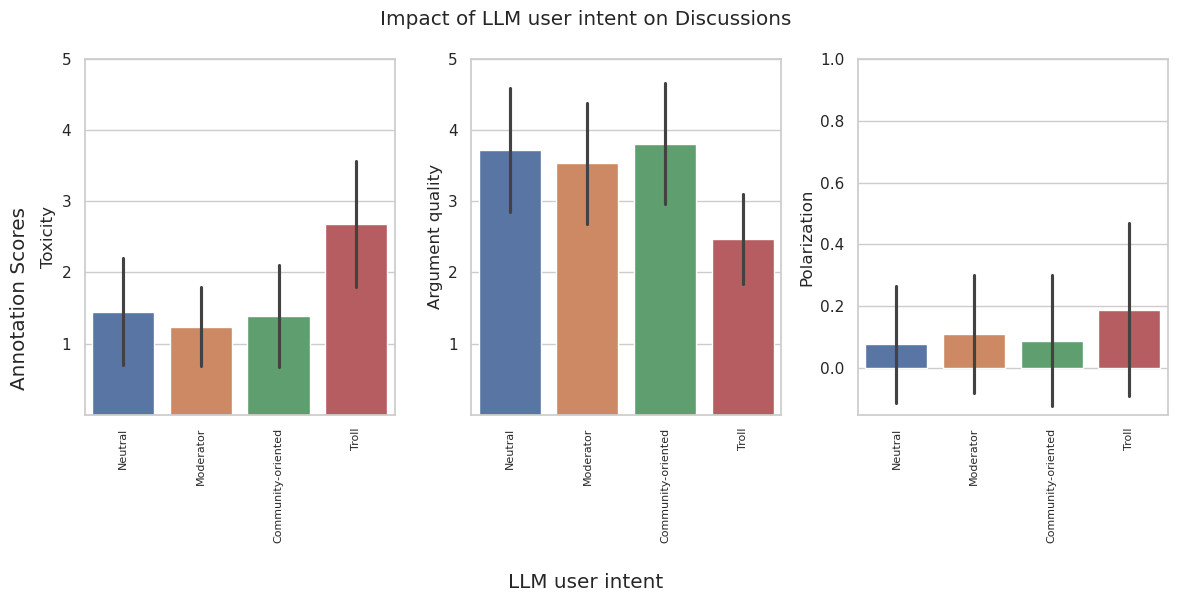

In [40]:
plot_metrics_barplots("intent", "LLM user intent")
save_plot(path=GRAPH_OUTPUT_DIR / "intent_barplot.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/strategy_barplot.png


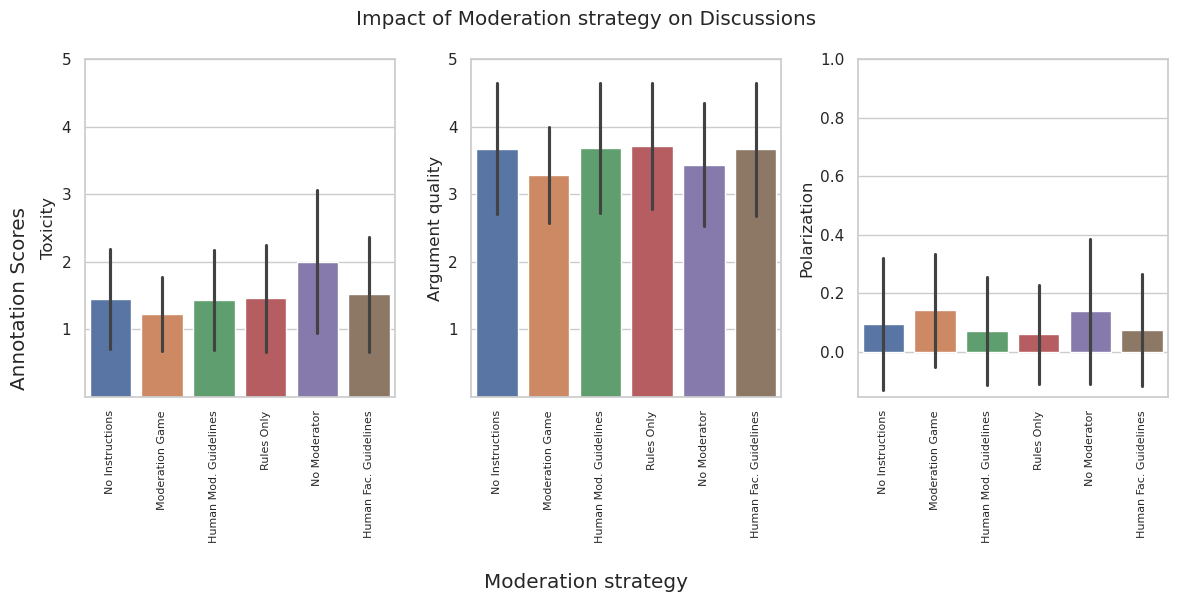

In [41]:
plot_metrics_barplots("conv_variant", "Moderation strategy")
save_plot(path=GRAPH_OUTPUT_DIR / "strategy_barplot.png")
plt.show()

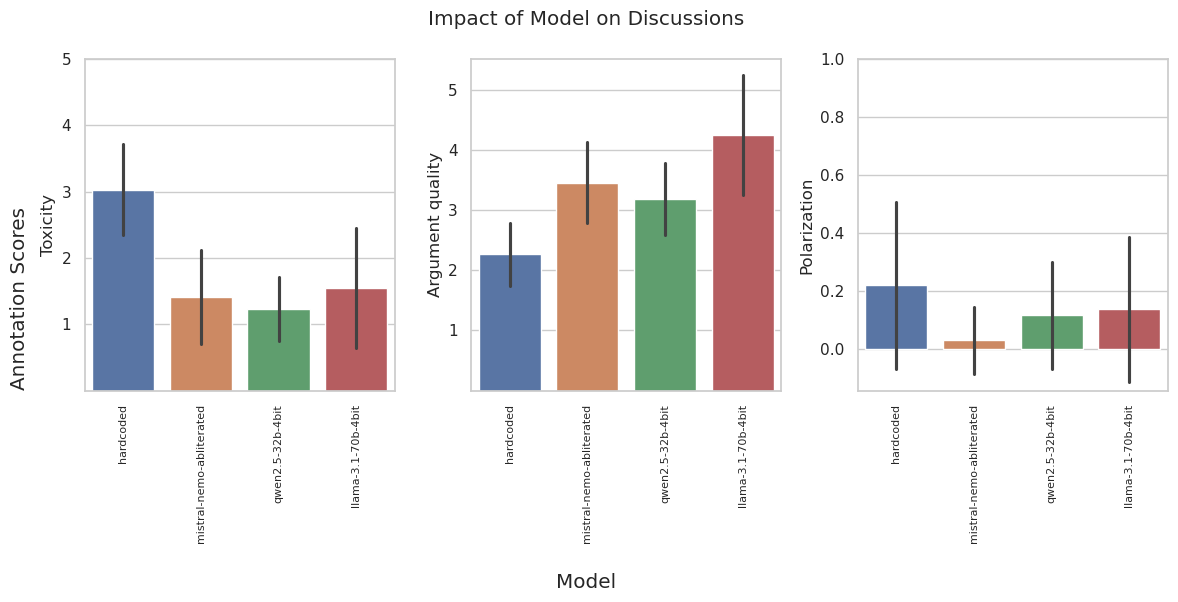

In [42]:
plot_metrics_barplots("model", "Model")
plt.show()

### Moderator impact

In [43]:
no_mod_df = df.copy()
no_mod_df = no_mod_df[~no_mod_df.is_moderator]
contains_mod = no_mod_df.conv_variant != "No Moderator"
no_mod_df.loc[contains_mod, "message_order"] = no_mod_df[contains_mod].message_order // 2  + 1

In [44]:
def plot_timeseries(df: pd.DataFrame, y_col: str, hue_col: str, hue_col_label: str) -> None:
    plt.figure(figsize=(12, 6))

    sns.lineplot(
        data=no_mod_df,
        x="message_order",
        y=y_col,
        hue=hue_col,
        lw=1,
        alpha=0.6,
    )

    plt.title(f"Average (all comments from all annotators) {y_col.capitalize()} by {hue_col_label}")
    plt.xlabel("Discussion Length (# messages)")
    plt.ylabel(f"Average {y_col.capitalize()}")
    plt.xticks(rotation=45)

    plt.legend(title=hue_col_label)
    plt.tight_layout()

### Intent Impact

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/intent_toxicity_timeseries.png


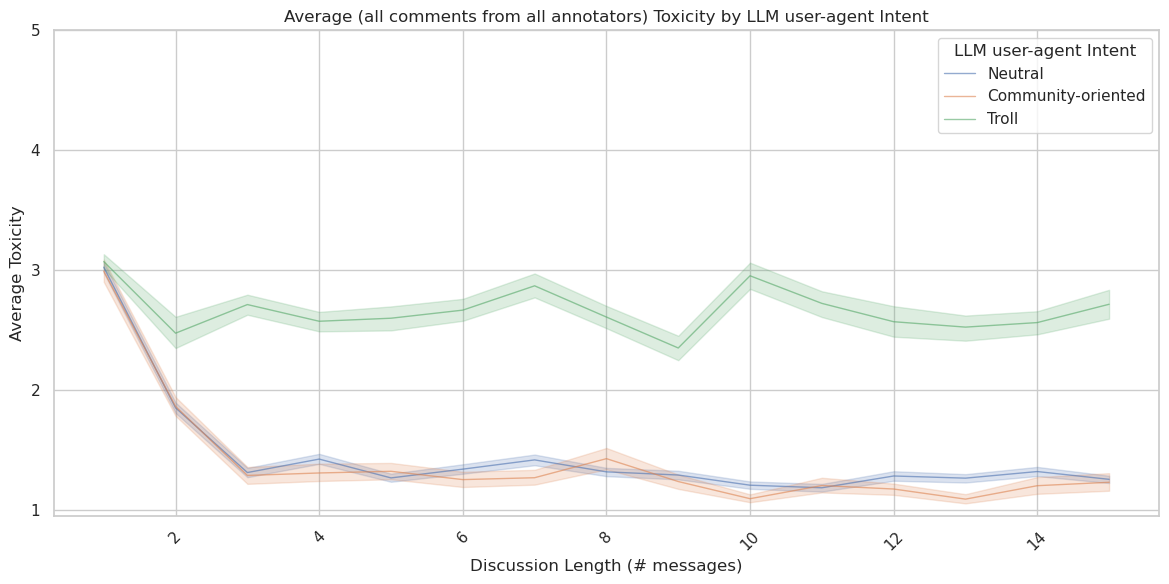

In [45]:
plot_timeseries(no_mod_df, y_col="toxicity", hue_col="intent", hue_col_label="LLM user-agent Intent")
plt.yticks(TOXICITY_TICKS)

save_plot(path=GRAPH_OUTPUT_DIR / "intent_toxicity_timeseries.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/intent_polarization_timeseries.png


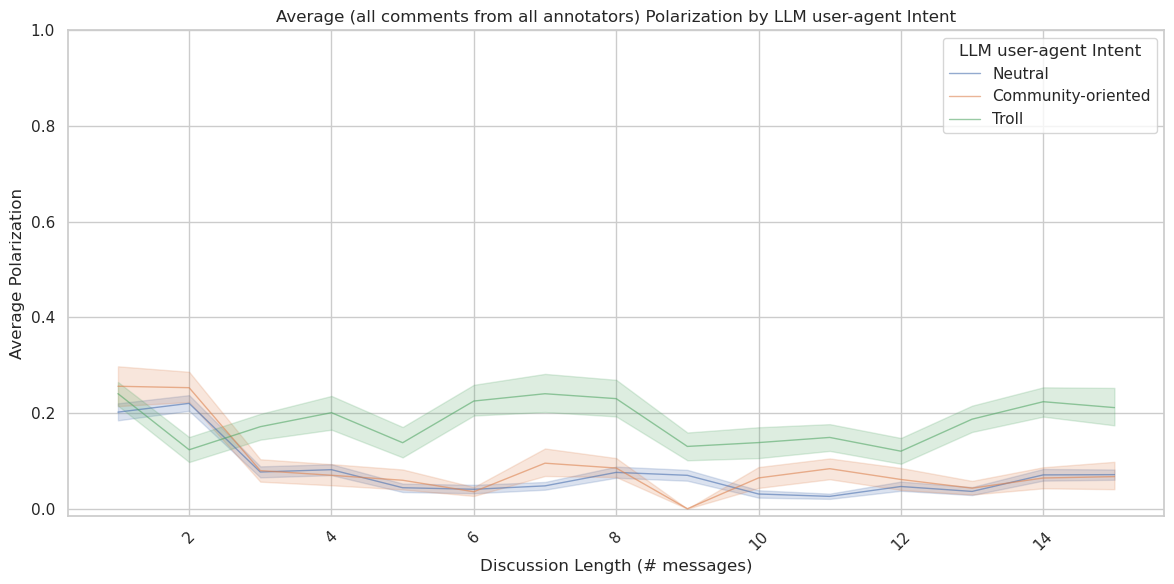

In [46]:
plot_timeseries(no_mod_df, y_col="polarization", hue_col="intent", hue_col_label="LLM user-agent Intent")
plt.yticks(POLARIZATION_TICKS)

save_plot(path=GRAPH_OUTPUT_DIR / "intent_polarization_timeseries.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/intent_argument_timeseries.png


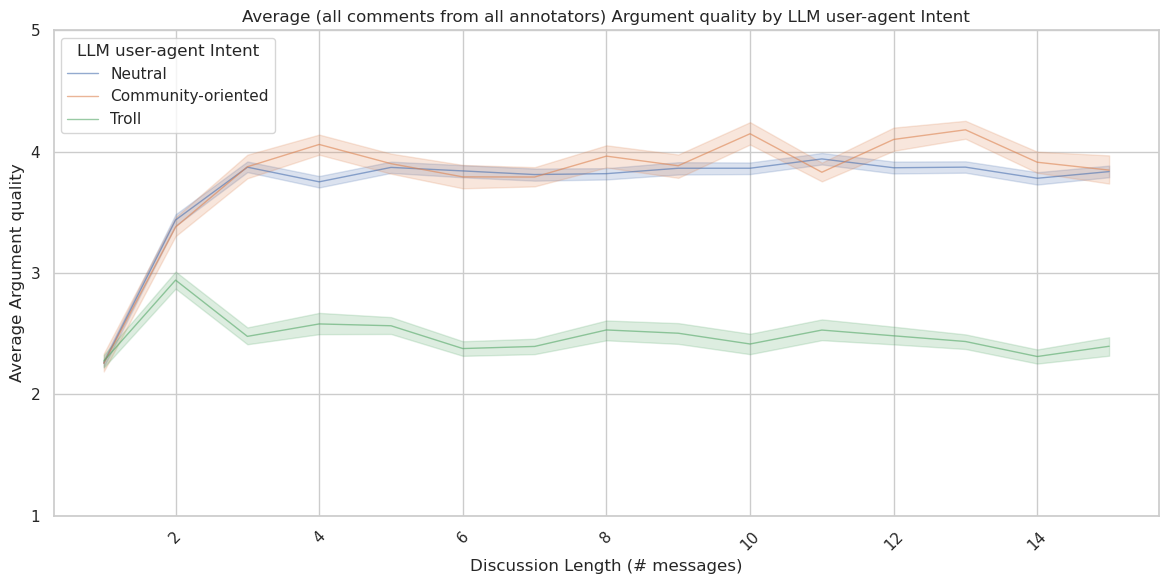

In [47]:
plot_timeseries(no_mod_df, y_col="Argument Quality", hue_col="intent", hue_col_label="LLM user-agent Intent")
plt.yticks(TOXICITY_TICKS)

save_plot(path=GRAPH_OUTPUT_DIR / "intent_argument_timeseries.png")
plt.show()

### Moderation Strategy Impact

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/strategy_toxicity_timeseries.png


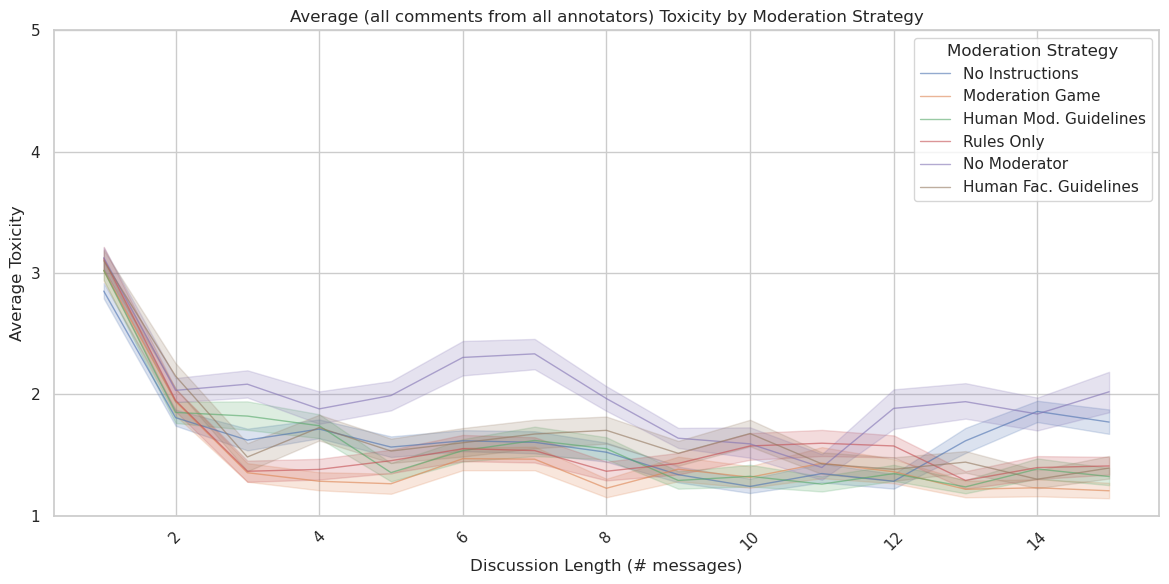

In [48]:
plot_timeseries(no_mod_df, y_col="toxicity", hue_col="conv_variant", hue_col_label="Moderation Strategy")
plt.yticks(TOXICITY_TICKS)

save_plot(path=GRAPH_OUTPUT_DIR / "strategy_toxicity_timeseries.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/strategy_polarization_timeseries.png


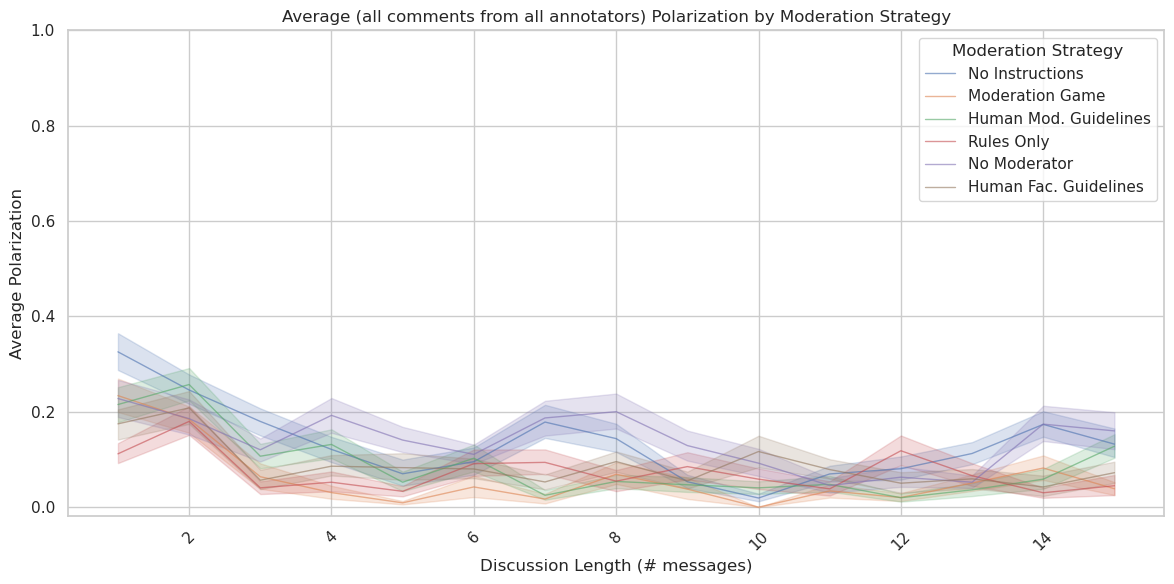

In [49]:
plot_timeseries(no_mod_df, y_col="polarization", hue_col="conv_variant", hue_col_label="Moderation Strategy")
plt.yticks(POLARIZATION_TICKS)

save_plot(path=GRAPH_OUTPUT_DIR / "strategy_polarization_timeseries.png")
plt.show()

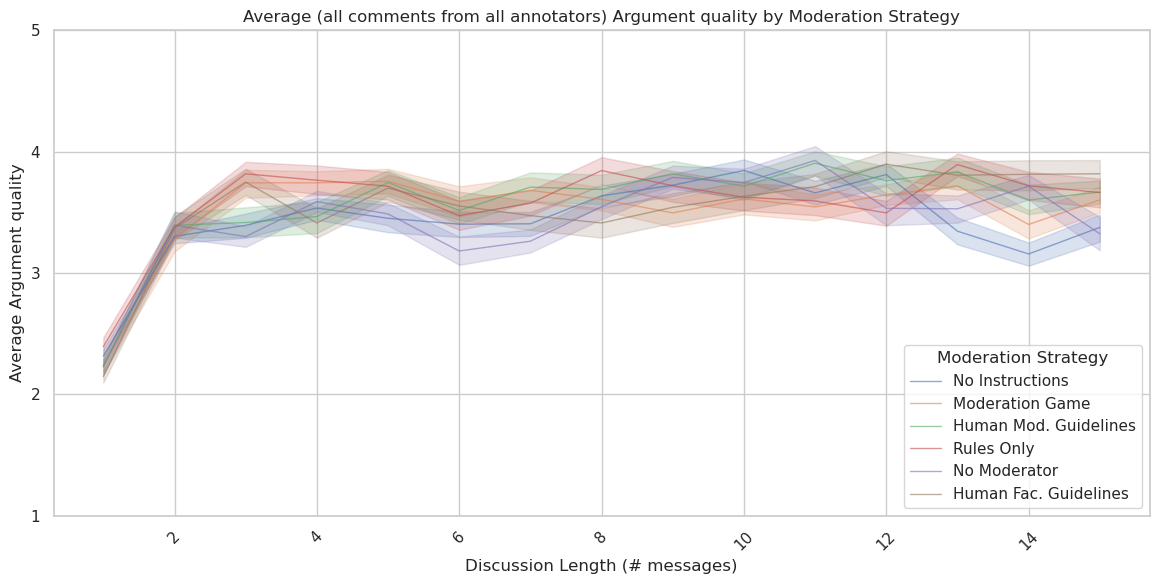

In [50]:
plot_timeseries(no_mod_df, y_col="Argument Quality", hue_col="conv_variant", hue_col_label="Moderation Strategy")
plt.yticks(TOXICITY_TICKS)
plt.show()

### Moderator Interventions

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/intervention_count.png


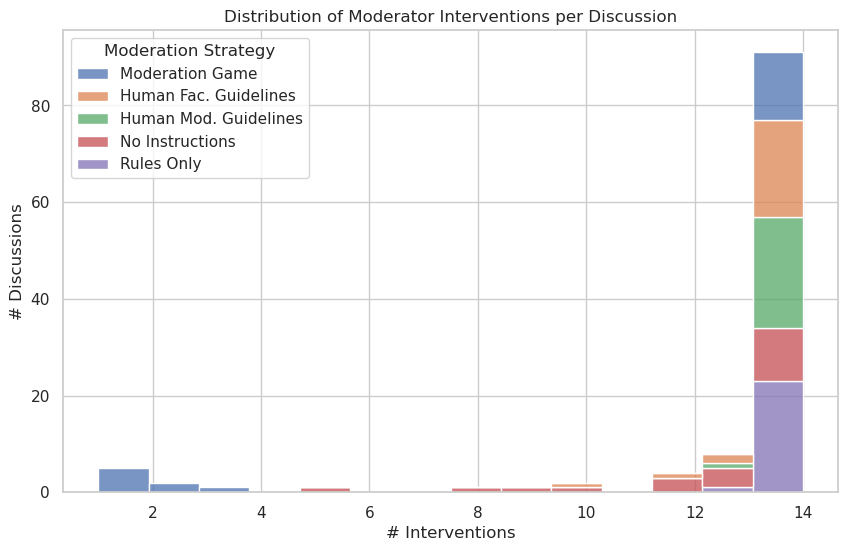

In [51]:
df_unique = df[df["conv_variant"] != "no_moderator"].drop_duplicates(
    subset=["message_id"]
)

# Compute number of moderator interventions per conversation
moderator_interventions = df_unique[df_unique["is_moderator"]].groupby("conv_id").size()

# Merge with conversation variants
conv_variants = (
    df_unique[["conv_id", "conv_variant"]].drop_duplicates().set_index("conv_id")
)
moderator_interventions = moderator_interventions.to_frame(
    name="moderator_interventions"
).join(conv_variants, how="left")

plt.figure(figsize=(10, 6))
sns.histplot(
    data=moderator_interventions.rename({"conv_variant": "Moderation Strategy"}, axis=1),
    x="moderator_interventions",
    hue="Moderation Strategy",
    multiple="stack",
    bins=14,
)
plt.xlabel("# Interventions")
plt.ylabel("# Discussions")
plt.title("Distribution of Moderator Interventions per Discussion")

save_plot(path=GRAPH_OUTPUT_DIR / "intervention_count.png")
plt.show()

### Annotators

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/polarization_toxicity.png


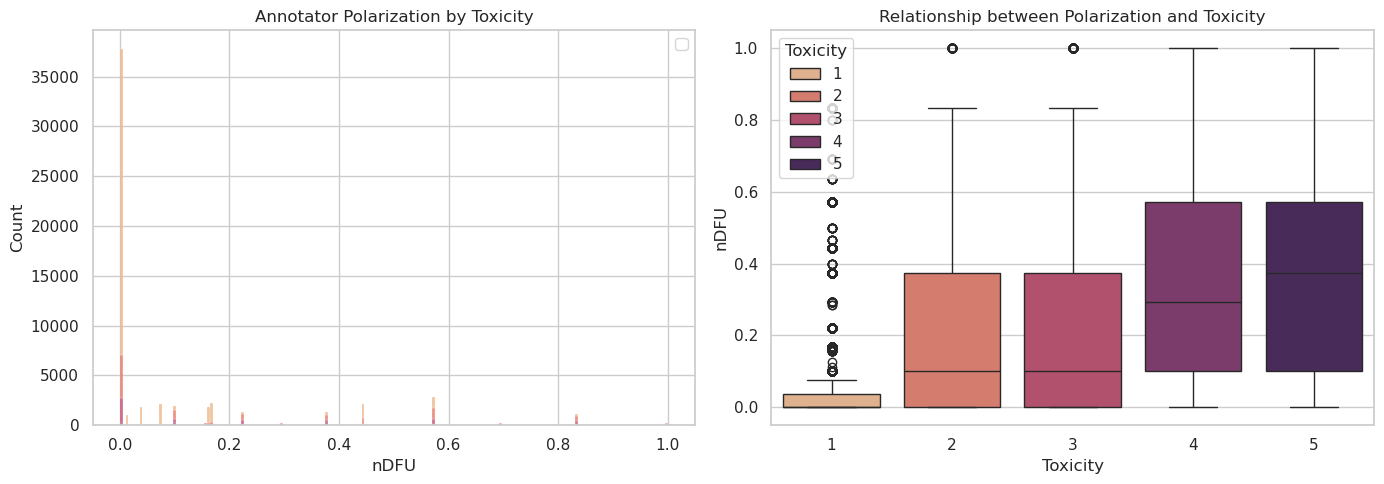

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df, x="polarization", hue="toxicity", palette="flare", multiple="stack", ax=axes[0])
axes[0].set_title("Annotator Polarization by Toxicity")
axes[0].set_xlabel("nDFU")
axes[0].legend("")

sns.boxplot(df, y="polarization", x="toxicity", hue="toxicity", palette="flare", ax=axes[1])
axes[1].set_title("Relationship between Polarization and Toxicity")
axes[1].set_xlabel("Toxicity")
axes[1].set_ylabel("nDFU")
axes[1].legend(title="Toxicity", loc="upper left")

plt.tight_layout()

save_plot(GRAPH_OUTPUT_DIR / "polarization_toxicity.png")
plt.show()


## Investigating the rise of vanilla annotations

In [53]:
def intent_ratio(sus_df, other_df):
    other_value_counts = other_df.intent.value_counts()
    other_ratio = other_value_counts["Troll"] / other_value_counts.sum() * 100

    sus_value_counts = sus_df.intent.value_counts()
    sus_ratio = sus_value_counts["Troll"] / sus_value_counts.sum() * 100

    print(f"Suspicious area troll/other ratio: {sus_ratio:.2f}%")
    print(f"Other area troll/other ratio: {other_ratio:.2f}%")


Explain vanilla bump:

In [54]:
vanilla_df = df[df.conv_variant=="No Instructions"]
sus_df = vanilla_df[(vanilla_df.message_order <= 28) & (vanilla_df.message_order >= 23)]
other_df = vanilla_df

intent_ratio(sus_df, other_df)

Suspicious area troll/other ratio: 13.51%
Other area troll/other ratio: 8.45%


Explain moderation game bump:

In [55]:
mod_game_df = df[df.conv_variant=="Moderation Game"]
sus_df = mod_game_df[(mod_game_df.message_order <= 22) & (mod_game_df.message_order >= 19)]
other_df = mod_game_df

intent_ratio(sus_df, other_df)

Suspicious area troll/other ratio: 1.75%
Other area troll/other ratio: 1.98%


Baseline: ratios on stable area

In [56]:
vanilla_df = df[df.conv_variant=="No Instructions"]
sus_df = vanilla_df[(vanilla_df.message_order <= 22) & (vanilla_df.message_order >= 19)]
other_df = vanilla_df

intent_ratio(sus_df, other_df)

Suspicious area troll/other ratio: 3.55%
Other area troll/other ratio: 8.45%


## Impact of models

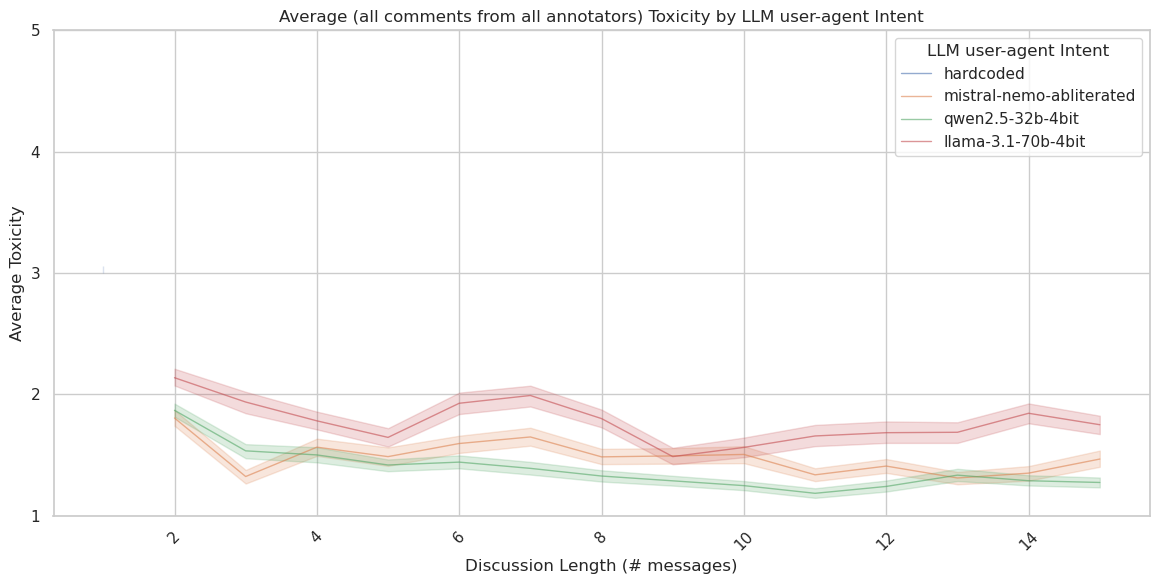

In [57]:
plot_timeseries(df, y_col="toxicity", hue_col="model", hue_col_label="LLM user-agent Intent")
plt.yticks(TOXICITY_TICKS)
plt.show()

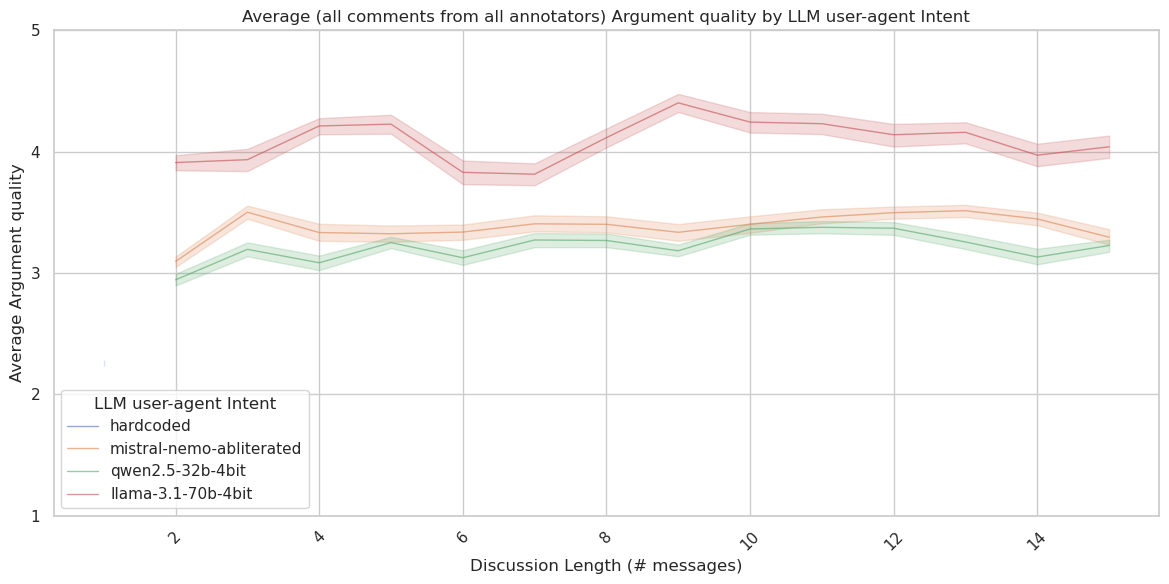

In [58]:
plot_timeseries(df, y_col="Argument Quality", hue_col="model", hue_col_label="LLM user-agent Intent")
plt.yticks(TOXICITY_TICKS)
plt.show()

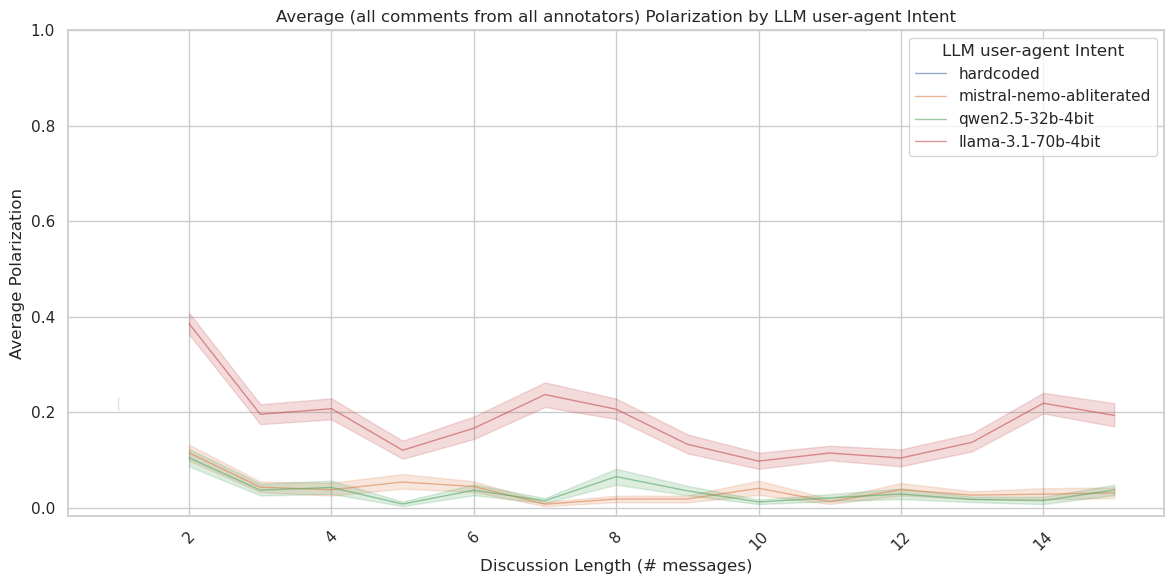

In [59]:
plot_timeseries(df, y_col="polarization", hue_col="model", hue_col_label="LLM user-agent Intent")
plt.yticks(POLARIZATION_TICKS)
plt.show()

## Investigating the impact of moderator interventions

Draw red lines when the moderator does not intervene

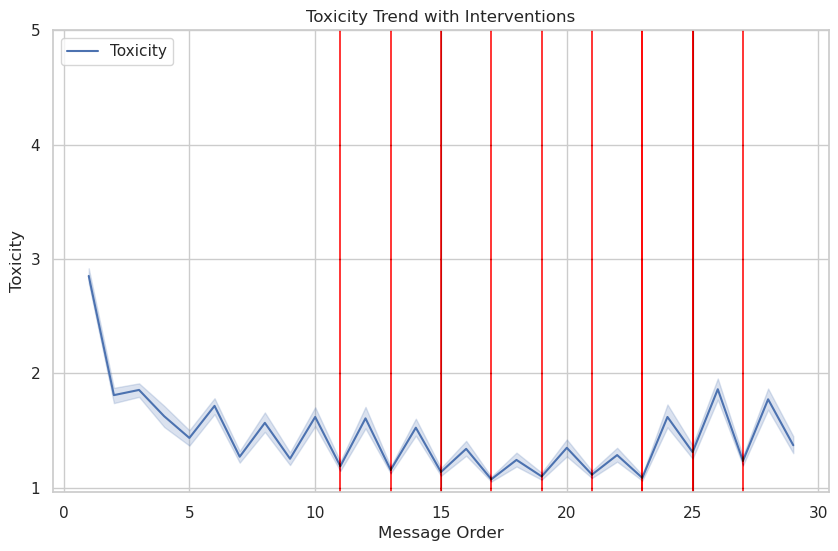

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter intervention data
intervention_df = full_df[full_df.conv_variant == "No Instructions"]

# Create the plot
plt.figure(figsize=(10, 6))

# Lineplot for toxicity over message order
sns.lineplot(data=intervention_df, x="message_order", y="toxicity", label="Toxicity")

# Add vertical dashed red lines where not_intervened is True
for msg_order in intervention_df.loc[intervention_df["not_intervened"], "message_order"]:
    plt.axvline(x=msg_order, color="red", linestyle="dashed", lw=0.02, alpha=0.2)

# Labels and title
plt.xlabel("Message Order")
plt.ylabel("Toxicity")
plt.title("Toxicity Trend with Interventions")
plt.yticks(TOXICITY_TICKS)

# Show plot
plt.show()


Repeat for each individual discussion

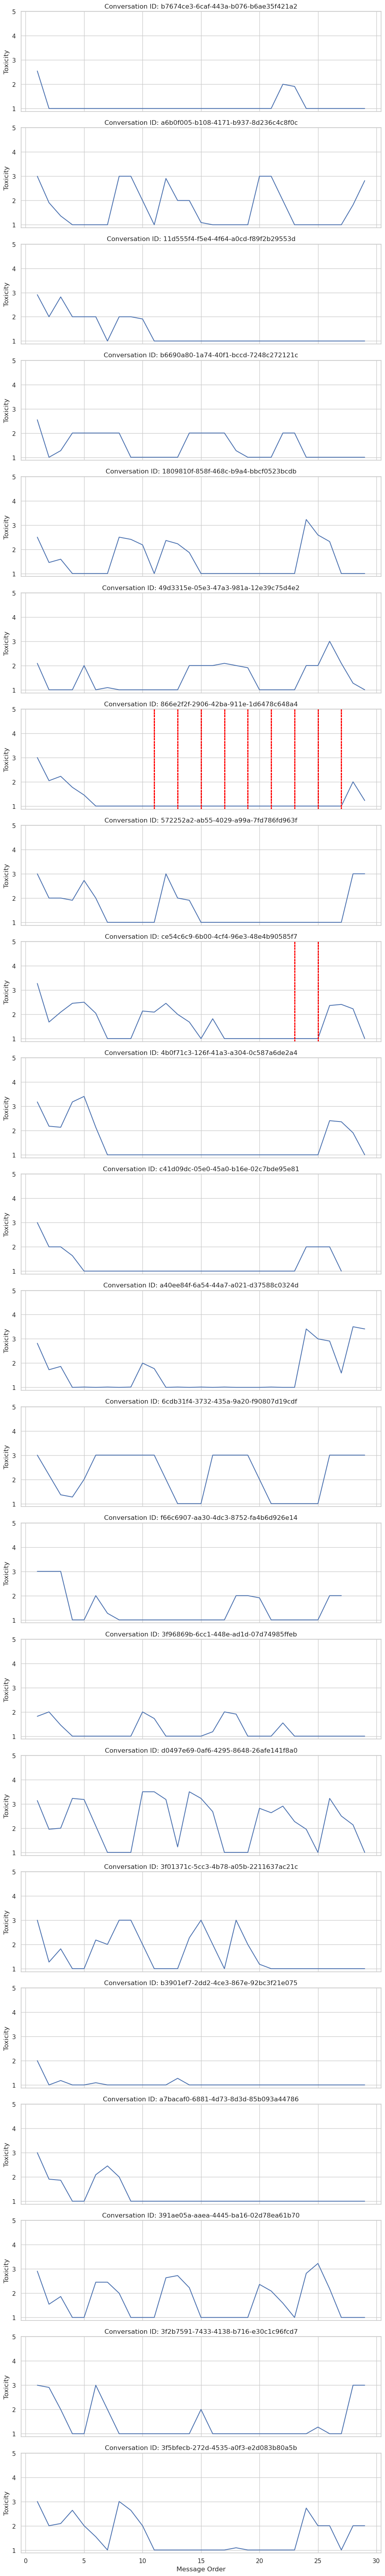

In [61]:
intervention_df = full_df[full_df.conv_variant == "No Instructions"]

# Create subplots (one for each conversation)
conv_ids = intervention_df.conv_id.unique()
fig, axes = plt.subplots(len(conv_ids), 1, figsize=(10, 3 * len(conv_ids)), sharex=True, sharey=True)

if len(conv_ids) == 1:
    axes = [axes]

for ax, conv_id in zip(axes, conv_ids):
    local_df = intervention_df[intervention_df.conv_id == conv_id]
    
    # Lineplot for toxicity trend
    sns.lineplot(data=local_df, x="message_order", y="toxicity", ax=ax, errorbar=None)
    
    # Add vertical dashed red lines for not_intervened points
    for msg_order in local_df.loc[local_df["not_intervened"], "message_order"]:
        ax.axvline(x=msg_order, color="red", linestyle="dashed", lw=1, alpha=0.5)
    
    ax.set_title(f"Conversation ID: {conv_id}")
    ax.set_ylabel("Toxicity")
    ax.set_yticks(TOXICITY_TICKS)


plt.xlabel("Message Order")
plt.tight_layout()
plt.show()


Non-interventions are an anomaly seen in mostly one discussion.

## Model Analysis

### Comment length

In [62]:
len_df = full_df.copy()
len_df["comment_length"] = len_df.message.apply(lambda x: len(x.split()))
len_df = len_df.loc[len_df.model != "hardcoded", ["message_id", "comment_length", "model"]]
len_df = len_df.drop_duplicates(subset=["message_id"])
len_df

,message_id,comment_length,model
11,-2040734123613032048,53,mistral-nemo-abliterated
22,350266975977766415,10,mistral-nemo-abliterated
33,-2041858288134007491,91,mistral-nemo-abliterated
44,-929371533580547490,10,mistral-nemo-abliterated
55,1921575520391489857,75,mistral-nemo-abliterated
...,...,...,...
61092,-1148478833479242344,50,mistral-nemo-abliterated
61103,1791343420821541649,105,mistral-nemo-abliterated
61114,-1193065505331857141,52,mistral-nemo-abliterated
61125,-2209182264457815901,121,mistral-nemo-abliterated


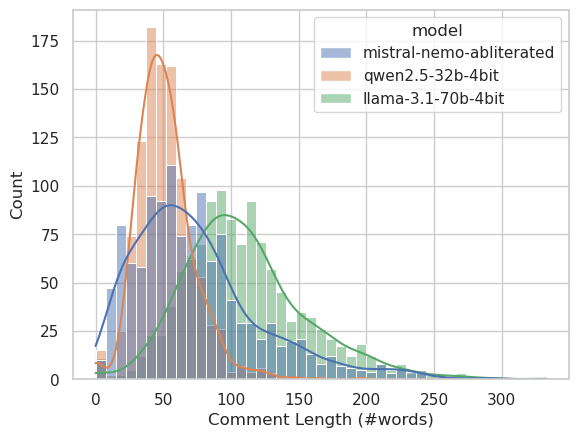

In [63]:
sns.histplot(len_df, x="comment_length", hue="model", kde=True)
plt.xlabel("Comment Length (#words)")
plt.show()

In [64]:
message_df = full_df.copy()
message_df = message_df.drop_duplicates(subset=["conv_id", "message_id"])
# @ tokens crash bleu scorer
message_df.message = message_df.message.apply(lambda msg: " ".join(word for word in msg.split() if not word.startswith("@")))

similarity_df = (
    message_df.groupby(["conv_id", "model"])['message']
    .apply(lambda messages: messages.tolist())
    .reset_index()
) 
similarity_df.columns = ["conv_id", "model", "messages"]
similarity_df = similarity_df[similarity_df.model != "hardcoded"] 

In [ ]:
similarity_df["rougel_similarity"] = similarity_df.messages.progress_apply(tasks.stats.pairwise_rougel_similarity)
similarity_df["bleu_similarity"] = similarity_df.messages.progress_apply(tasks.stats.pairwise_bleu_similarity)

  0%|          | 0/140 [00:00<?, ?it/s]

 66%|██████▌   | 92/140 [01:18<00:32,  1.50it/s]

In [ ]:
sns.histplot(similarity_df, x="rougel_similarity", hue="model", kde=True)
plt.xlabel("Average pairwise F1 ROUGE-L")
plt.title("Intra-discussion variance")
plt.show()

In [ ]:
sns.histplot(similarity_df, x="bleu_similarity", hue="model", kde=True)
plt.xlabel("Average pairwise F1 ROUGE-L")
plt.title("Intra-discussion variance")
plt.show()